# Imports

In [ ]:
!pip install nltk spacy
!python -m spacy download en_core_web_sm
!pip install vaderSentiment

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 27.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 3.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import networkx as nx
import json
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn import feature_extraction
import re
import nltk
import spacy
from nltk.corpus import stopwords
from collections import Counter
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import os
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import average_precision_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Loading PolitiFact Dataset

In [ ]:
# Load the news-user sharing relationships
news_user_df = pd.read_csv('/content/drive/MyDrive/SMM_POLITIFACT/PolitiFact/PolitiFactNewsUser.txt', sep='\t', header=None, names=['news_id', 'user_id', 'share_count'])
news_user_df.head()

,news_id,user_id,share_count
0,240,1,1
1,124,2,1
2,162,3,1
3,233,4,1
4,50,5,1


In [ ]:
news_user_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32791 entries, 0 to 32790
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   news_id      32791 non-null  int64
 1   user_id      32791 non-null  int64
 2   share_count  32791 non-null  int64
dtypes: int64(3)
memory usage: 768.7 KB


In [ ]:
# Load the user-user following relationships
user_user_df = pd.read_csv('/content/drive/MyDrive/SMM_POLITIFACT/PolitiFact/PolitiFactUserUser.txt', sep='\t', header=None, names=['follower_id', 'followee_id'])
user_user_df.head()

,follower_id,followee_id
0,507,1
1,1589,1
2,5307,1
3,11421,1
4,13267,1


In [ ]:
user_user_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 574744 entries, 0 to 574743
Data columns (total 2 columns):
 #   Column       Non-Null Count   Dtype
---  ------       --------------   -----
 0   follower_id  574744 non-null  int64
 1   followee_id  574744 non-null  int64
dtypes: int64(2)
memory usage: 8.8 MB


In [ ]:
# Load the news data
news_df = pd.read_csv('/content/drive/MyDrive/SMM_POLITIFACT/PolitiFact/News.txt', sep='\t', header=None, names=['news_id'])
news_df.head()

,news_id
0,PolitiFact_Real_1
1,PolitiFact_Real_2
2,PolitiFact_Real_3
3,PolitiFact_Real_4
4,PolitiFact_Real_5


In [ ]:
news_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   news_id  240 non-null    object
dtypes: object(1)
memory usage: 2.0+ KB


In [ ]:
# Load the users data
user_df = pd.read_csv('/content/drive/MyDrive/SMM_POLITIFACT/PolitiFact/User.txt', sep='\t', header=None, names=['user_id'])
user_df.head()

,user_id
0,f4b46be21c2f553811cc8a73c4f0ff05
1,2ced3734cc9c164edd9a8f5fbebe976f
2,c84c4ea8ba67211f84781bdd64cafe43
3,1776d1765f5e82cd660d8d502f227402
4,4e8c2c300d96929895ce0edba915af16


In [ ]:
user_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23865 entries, 0 to 23864
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  23865 non-null  object
dtypes: object(1)
memory usage: 186.6+ KB


# **Data Statistics**

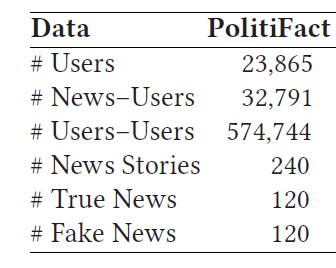

# Loading 'news' metadata

In [ ]:
# Define the directories for fake and real news
fake_news_dir = '/content/drive/MyDrive/SMM_POLITIFACT/PolitiFact/FakeNewsContent'
real_news_dir = '/content/drive/MyDrive/SMM_POLITIFACT/PolitiFact/RealNewsContent'

# Function to load all news files from a directory
def load_news_files(news_dir):
    news_data = []
    for filename in os.listdir(news_dir):
        if filename.endswith('.json'):
            with open(os.path.join(news_dir, filename)) as f:
                news = json.load(f)
                news['news_id'] = filename.split('-')[0].split('_')[-1]  # Add the news ID from the filename
                news_data.append(news)
    return news_data

# Load fake and real news files
fake_news_data = load_news_files(fake_news_dir)
real_news_data = load_news_files(real_news_dir)


In [ ]:
len(fake_news_data)

120

In [ ]:
len(real_news_data)

120

## Merging the 'fake' and 'real' news datasets into one dataframe

In [ ]:

# Convert the lists of dictionaries into Pandas DataFrames
fake_news_df = pd.DataFrame(fake_news_data)
real_news_df = pd.DataFrame(real_news_data)

# Add a label column: 0 for fake, 1 for real
fake_news_df['label'] = 0
real_news_df['label'] = 1

# Combine the two DataFrames
news_df = pd.concat([fake_news_df, real_news_df], ignore_index=True)
news_df.head()

,top_img,text,authors,keywords,meta_data,canonical_link,images,title,url,summary,movies,publish_date,source,news_id,label
0,https://i1.wp.com/thelastlineofdefense.org/wp-...,Join America's Last Line of Defense And Share ...,"[About Stryker, Stryker Is A Constitutional Co...",[],"{'generator': 'WordPress 4.8', 'og': {'site_na...",http://thelastlineofdefense.org/breaking-presi...,[http://thelastlineofdefense.org/wp-content/up...,President Trump Just Told Paul Ryan ‘You’re Fi...,http://thelastlineofdefense.org/breaking-presi...,,[],{'$date': 1489515548000},http://thelastlineofdefense.org,50,0
1,NaN,There have been many reports about the changes...,NaN,NaN,NaN,NaN,NaN,NASA Confirms Earth Will Experience 15 Days Of...,NaN,NaN,NaN,NaN,NaN,94,0
2,http://newsfeedhunter.com/wp-content/uploads/2...,The DEA just raided the vacation ranch of Demo...,[],[],{'description': 'The DEA just raided the vacat...,http://newsfeedhunter.com/the-dea-just-raided-...,[http://2.gravatar.com/avatar/2f3050879f2ba38f...,The DEA Just Raided A United States Senator–De...,http://newsfeedhunter.com/the-dea-just-raided-...,,[],{'$date': 1497104737000},http://newsfeedhunter.com,93,0
3,NaN,Obama’s military command will prevent delivery...,NaN,NaN,NaN,NaN,NaN,War on Christmas Obama orders ban on Christmas...,NaN,NaN,NaN,NaN,NaN,11,0
4,http://politicot.com/wp-content/uploads/2013/0...,House Speaker Paul Ryan (R-WI) this week dispu...,[],[],"{'description': 'satire, satire article, satir...",http://politicot.com/paul-ryan-22-million-amer...,[http://politicot.com/wp-content/uploads/2015/...,Paul Ryan: “22 Million Americans Choose To Be ...,http://politicot.com/paul-ryan-22-million-amer...,,[],{'$date': 1498609095000},http://politicot.com,111,0


In [ ]:
news_df.tail()

,top_img,text,authors,keywords,meta_data,canonical_link,images,title,url,summary,movies,publish_date,source,news_id,label
235,http://eaglerising.com/wp-content/uploads/2016...,A 22-year-old Muslim man from Afghanistan prou...,"[View All Posts, Tim Brown]",[],"{'description': '""I'm a superstar in Afghanist...",http://eaglerising.com/36944/muslim-afghani-ra...,[http://constitution.com/wp-content/uploads/20...,"Muslim Afghani Rapes 2-YEAR-OLD, Gets 2 Years ...",http://eaglerising.com/36944/muslim-afghani-ra...,,[],{'$date': 1474527602000},http://eaglerising.com,119,1
236,http://a.abcnews.com/images/Politics/AP_hofstr...,An anti-Donald Trump super PAC is going on the...,"[More Michael, Abc News]",[],{'fb_title': 'Anti-Trump Super PAC Launches Pr...,http://abcnews.go.com/Politics/anti-trump-supe...,[http://www.googleadservices.com/pagead/conver...,Anti-Trump Super PAC Launches Pre-Debate Video...,http://abcn.ws/2dgPtRo,,[https://www.youtube.com/embed/KrKIWu0zrV8],None,http://abcn.ws,106,1
237,http://i2.cdn.cnn.com/cnnnext/dam/assets/16020...,"Story highlights ""I don't know how you could h...","[Eugene Scott, Daniella Diaz]",[],{'description': 'New York Gov. Andrew Cuomo sa...,http://www.cnn.com/2016/09/19/politics/andrew-...,[http://i2.cdn.turner.com/cnn/2016/images/04/2...,NY Gov. Andrew Cuomo disputes Trump's claim co...,http://cnn.it/2d3tTeL,,[],None,http://cnn.it,108,1
238,http://www.politico.eu/wp-content/uploads/2016...,"KALLSTADT, Germany — Few places in Germany are...","[Matthew Karnitschnig, Janosch Delcker]",[],{'description': 'In the idyllic hamlet of Kall...,http://www.politico.eu/article/donald-trump-an...,[http://g8fip1kplyr33r3krz5b97d1.wpengine.netd...,"Donald Trump, Germany’s disfavored son – POLITICO",http://politi.co/2csN1WG,,[],{'$date': 1474601447000},http://politi.co,95,1
239,http://i2.cdn.cnn.com/cnnnext/dam/assets/15111...,Story highlights Ahmad Khan Raham is alleged t...,"[Steve Vladeck, Cnn Contributor]",[],{'description': 'The arrest of Ahmad Khan Raha...,http://www.cnn.com/2016/09/20/politics/legal-r...,[http://i2.cdn.cnn.com/cnnnext/dam/assets/1609...,What the US government can and cannot do to US...,http://cnn.it/2d6Dcug,,[],None,http://cnn.it,75,1


In [ ]:
news_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   top_img         209 non-null    object
 1   text            240 non-null    object
 2   authors         209 non-null    object
 3   keywords        209 non-null    object
 4   meta_data       209 non-null    object
 5   canonical_link  209 non-null    object
 6   images          209 non-null    object
 7   title           240 non-null    object
 8   url             209 non-null    object
 9   summary         209 non-null    object
 10  movies          209 non-null    object
 11  publish_date    164 non-null    object
 12  source          209 non-null    object
 13  news_id         240 non-null    object
 14  label           240 non-null    int64 
dtypes: int64(1), object(14)
memory usage: 28.2+ KB


In [ ]:
news_df.isna().sum()

,0
top_img,31
text,0
authors,31
keywords,31
meta_data,31
canonical_link,31
images,31
title,0
url,31
summary,31


In [ ]:
news_df.iloc[22]

,22
top_img,NaN
text,"Terror suspect, Rasheed Muhammad, was arrested..."
authors,NaN
keywords,NaN
meta_data,NaN
canonical_link,NaN
images,NaN
title,Executive Order Leads to Capture of ISIS Leade...
url,NaN
summary,NaN


# Feature Engineering -

 (A) Features describing **news content**

 (B) Features describing **social network between users** and **user-news sharing relationship**



 We implement these one by one -

 ### (A) Features describing **news content**-

- Extracting **title-length** and **body-length** features-

In [ ]:
news_df['title_length'] = news_df['title'].apply(len)
news_df['body_length'] = news_df['text'].apply(len)
news_df.head()

,top_img,text,authors,keywords,meta_data,canonical_link,images,title,url,summary,movies,publish_date,source,news_id,label,title_length,body_length
0,https://i1.wp.com/thelastlineofdefense.org/wp-...,Join America's Last Line of Defense And Share ...,"[About Stryker, Stryker Is A Constitutional Co...",[],"{'generator': 'WordPress 4.8', 'og': {'site_na...",http://thelastlineofdefense.org/breaking-presi...,[http://thelastlineofdefense.org/wp-content/up...,President Trump Just Told Paul Ryan ‘You’re Fi...,http://thelastlineofdefense.org/breaking-presi...,,[],{'$date': 1489515548000},http://thelastlineofdefense.org,50,0,82,2079
1,NaN,There have been many reports about the changes...,NaN,NaN,NaN,NaN,NaN,NASA Confirms Earth Will Experience 15 Days Of...,NaN,NaN,NaN,NaN,NaN,94,0,72,2251
2,http://newsfeedhunter.com/wp-content/uploads/2...,The DEA just raided the vacation ranch of Demo...,[],[],{'description': 'The DEA just raided the vacat...,http://newsfeedhunter.com/the-dea-just-raided-...,[http://2.gravatar.com/avatar/2f3050879f2ba38f...,The DEA Just Raided A United States Senator–De...,http://newsfeedhunter.com/the-dea-just-raided-...,,[],{'$date': 1497104737000},http://newsfeedhunter.com,93,0,78,1174
3,NaN,Obama’s military command will prevent delivery...,NaN,NaN,NaN,NaN,NaN,War on Christmas Obama orders ban on Christmas...,NaN,NaN,NaN,NaN,NaN,11,0,64,2720
4,http://politicot.com/wp-content/uploads/2013/0...,House Speaker Paul Ryan (R-WI) this week dispu...,[],[],"{'description': 'satire, satire article, satir...",http://politicot.com/paul-ryan-22-million-amer...,[http://politicot.com/wp-content/uploads/2015/...,Paul Ryan: “22 Million Americans Choose To Be ...,http://politicot.com/paul-ryan-22-million-amer...,,[],{'$date': 1498609095000},http://politicot.com,111,0,113,3474


In [ ]:
news_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   top_img         209 non-null    object
 1   text            240 non-null    object
 2   authors         209 non-null    object
 3   keywords        209 non-null    object
 4   meta_data       209 non-null    object
 5   canonical_link  209 non-null    object
 6   images          209 non-null    object
 7   title           240 non-null    object
 8   url             209 non-null    object
 9   summary         209 non-null    object
 10  movies          209 non-null    object
 11  publish_date    164 non-null    object
 12  source          209 non-null    object
 13  news_id         240 non-null    object
 14  label           240 non-null    int64 
 15  title_length    240 non-null    int64 
 16  body_length     240 non-null    int64 
dtypes: int64(3), object(14)
memory usage: 32.0+ KB


- Extracting **day of the week** and **is_weekend** features-

In [ ]:
news_df['publish_date'] = news_df['publish_date'].apply(
    lambda x: pd.to_datetime(x['$date'], unit='ms') if isinstance(x, dict) and '$date' in x else pd.NaT
)

news_df['publish_date']

,publish_date
0,2017-03-14 18:19:08
1,NaT
2,2017-06-10 14:25:37
3,NaT
4,2017-06-28 00:18:15
...,...
235,2016-09-22 07:00:02
236,NaT
237,NaT
238,2016-09-23 03:30:47


In [ ]:
news_df['day_of_week'] = news_df['publish_date'].dt.dayofweek
news_df['is_weekend'] = news_df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)
news_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   top_img         209 non-null    object        
 1   text            240 non-null    object        
 2   authors         209 non-null    object        
 3   keywords        209 non-null    object        
 4   meta_data       209 non-null    object        
 5   canonical_link  209 non-null    object        
 6   images          209 non-null    object        
 7   title           240 non-null    object        
 8   url             209 non-null    object        
 9   summary         209 non-null    object        
 10  movies          209 non-null    object        
 11  publish_date    164 non-null    datetime64[ns]
 12  source          209 non-null    object        
 13  news_id         240 non-null    object        
 14  label           240 non-null    int64         
 15  title_

###  (B) Features describing **social network between users** and **user-news sharing relationship**

- Total **number of unique users who shared the news**: Indicates the reach or popularity of a news article.
- Total **number of shares for a news** article: More number of shares indicates more popularity of the news
- **Average number of shares per user**: Indicate bot-like behavior or unusual activity.


In [ ]:
# Aggregate user engagement features for each news article
news_user_agg = news_user_df.groupby('news_id').agg(
    total_shares=('share_count', 'sum'),
    unique_users=('user_id', 'nunique'),
    avg_shares_per_user=('share_count', 'mean')
).reset_index()

news_df['news_id'] = news_df['news_id'].astype(int)

# Merge the user engagement features with the news_df (by news_id)
news_df = news_df.merge(news_user_agg, on='news_id', how='left')

# Fill NaN values with 0 (for news articles that were not shared)
news_df.fillna(0, inplace=True)
news_df.head()

<ipython-input-26-9dac89c3a252>:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  news_df.fillna(0, inplace=True)


,top_img,text,authors,keywords,meta_data,canonical_link,images,title,url,summary,...,source,news_id,label,title_length,body_length,day_of_week,is_weekend,total_shares,unique_users,avg_shares_per_user
0,https://i1.wp.com/thelastlineofdefense.org/wp-...,Join America's Last Line of Defense And Share ...,"[About Stryker, Stryker Is A Constitutional Co...",[],"{'generator': 'WordPress 4.8', 'og': {'site_na...",http://thelastlineofdefense.org/breaking-presi...,[http://thelastlineofdefense.org/wp-content/up...,President Trump Just Told Paul Ryan ‘You’re Fi...,http://thelastlineofdefense.org/breaking-presi...,,...,http://thelastlineofdefense.org,50,0,82,2079,1.0,0,173,168,1.029762
1,0,There have been many reports about the changes...,0,0,0,0,0,NASA Confirms Earth Will Experience 15 Days Of...,0,0,...,0,94,0,72,2251,0.0,0,347,324,1.070988
2,http://newsfeedhunter.com/wp-content/uploads/2...,The DEA just raided the vacation ranch of Demo...,[],[],{'description': 'The DEA just raided the vacat...,http://newsfeedhunter.com/the-dea-just-raided-...,[http://2.gravatar.com/avatar/2f3050879f2ba38f...,The DEA Just Raided A United States Senator–De...,http://newsfeedhunter.com/the-dea-just-raided-...,,...,http://newsfeedhunter.com,93,0,78,1174,5.0,1,26,24,1.083333
3,0,Obama’s military command will prevent delivery...,0,0,0,0,0,War on Christmas Obama orders ban on Christmas...,0,0,...,0,11,0,64,2720,0.0,0,37,32,1.156250
4,http://politicot.com/wp-content/uploads/2013/0...,House Speaker Paul Ryan (R-WI) this week dispu...,[],[],"{'description': 'satire, satire article, satir...",http://politicot.com/paul-ryan-22-million-amer...,[http://politicot.com/wp-content/uploads/2015/...,Paul Ryan: “22 Million Americans Choose To Be ...,http://politicot.com/paul-ryan-22-million-amer...,,...,http://politicot.com,111,0,113,3474,2.0,0,7,7,1.000000



- **Number of followers**of the users who shared the news: If someone with high number of followers share a piece of news, it is more likely to spread.
- **Number of followings** of the users who shared the news: If the person sharing a news is following a large number of people, this can give some indication of news virality as well.


In [ ]:
# Calculate the number of followers and followings for each user
followers_agg = user_user_df.groupby('followee_id').size().reset_index(name='num_followers')
followings_agg = user_user_df.groupby('follower_id').size().reset_index(name='num_followings')

# Merge the followers and followings information with the news-user relationship data
news_user_df = news_user_df.merge(followers_agg, left_on='user_id', right_on='followee_id', how='left')
news_user_df = news_user_df.merge(followings_agg, left_on='user_id', right_on='follower_id', how='left')

# Now, aggregate these new features by news_id (to create features at the news level)
user_influence_agg = news_user_df.groupby('news_id').agg(
    avg_followers=('num_followers', 'mean'),
    avg_followings=('num_followings', 'mean')
).reset_index()

# Merge the user influence features with the main news dataframe
news_df = news_df.merge(user_influence_agg, on='news_id', how='left')

# Again, fill NaN values with 0 (for news articles that were not shared)
news_df.fillna(0, inplace=True)

news_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   top_img              240 non-null    object 
 1   text                 240 non-null    object 
 2   authors              240 non-null    object 
 3   keywords             240 non-null    object 
 4   meta_data            240 non-null    object 
 5   canonical_link       240 non-null    object 
 6   images               240 non-null    object 
 7   title                240 non-null    object 
 8   url                  240 non-null    object 
 9   summary              240 non-null    object 
 10  movies               240 non-null    object 
 11  publish_date         240 non-null    object 
 12  source               240 non-null    object 
 13  news_id              240 non-null    int64  
 14  label                240 non-null    int64  
 15  title_length         240 non-null    int


- **Centrality measures** (like degree centrality) of users who share the news gives how fast the news spreads.


In [ ]:
import networkx as nx

# Create a directed graph from the user-user relationships
G = nx.DiGraph()

# Add edges to the graph
for _, row in user_user_df.iterrows():
    G.add_edge(row['follower_id'], row['followee_id'])

# Compute degree centrality for all users
centrality = nx.degree_centrality(G)

# Map the centrality score to users in the news-user dataframe
news_user_df['centrality'] = news_user_df['user_id'].map(centrality)

# Aggregate the centrality score by news_id
centrality_agg = news_user_df.groupby('news_id').agg(
    avg_centrality=('centrality', 'mean')
).reset_index()

# Merge the centrality feature with the main news dataframe
news_df = news_df.merge(centrality_agg, on='news_id', how='left')

# Fill NaN values with 0
news_df.fillna(0, inplace=True)
news_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   top_img              240 non-null    object 
 1   text                 240 non-null    object 
 2   authors              240 non-null    object 
 3   keywords             240 non-null    object 
 4   meta_data            240 non-null    object 
 5   canonical_link       240 non-null    object 
 6   images               240 non-null    object 
 7   title                240 non-null    object 
 8   url                  240 non-null    object 
 9   summary              240 non-null    object 
 10  movies               240 non-null    object 
 11  publish_date         240 non-null    object 
 12  source               240 non-null    object 
 13  news_id              240 non-null    int64  
 14  label                240 non-null    int64  
 15  title_length         240 non-null    int

# Feature Extraction

In [ ]:
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nlp = spacy.load("en_core_web_sm")
stop_words = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
def extract_features(text):
    # Initial processing with spaCy
    doc = nlp(text)

    # Feature variables
    features = {}

    # 1. Basic Counts
    features['word_count'] = len([token.text for token in doc if token.is_alpha])  # Count words only
    features['words_per_sentence'] = features['word_count'] / max(1, len(list(doc.sents)))

    # 2. Negation count
    negations = ['no', 'not', "n't", 'never', 'none']
    features['negation_count'] = sum(1 for token in doc if token.text.lower() in negations)

    # 3. Punctuation and Quote Counts
    features['punctuation_count'] = sum(1 for token in doc if token.is_punct)
    features['quote_count'] = text.count('"') + text.count("'")

    # 4. POS Counts
    pos_counts = Counter([token.pos_ for token in doc])
    features['noun_count'] = pos_counts.get('NOUN', 0)
    features['proper_noun_count'] = pos_counts.get('PROPN', 0)
    features['determiner_count'] = pos_counts.get('DET', 0)
    features['adverb_count'] = pos_counts.get('ADV', 0)
    features['adjective_count'] = pos_counts.get('ADJ', 0)
    features['verb_3rd_person_singular_present_count'] = sum(1 for token in doc if token.tag_ == 'VBZ')  # 3rd person singular verbs

    # 5. Stop Words and Uppercase Words Count
    features['stop_word_count'] = sum(1 for token in doc if token.text.lower() in stop_words)
    features['uppercase_word_count'] = sum(1 for token in doc if token.is_alpha and token.text.isupper())

    return features

In [ ]:
# Initialize the VADER sentiment intensity analyzer
analyzer = SentimentIntensityAnalyzer()

# Function to categorize sentiment
def get_sentiment(text):
    sentiment_score = analyzer.polarity_scores(text)
    compound_score = sentiment_score['compound']

    # Categorizing based on compound score
    if compound_score >= 0.05:
        return 'positive'
    elif compound_score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

In [ ]:
# Initialize lists to store features for each row
title_features_list = []
text_features_list = []
titles = []
texts = []
title_sentiments = []  # New list to store title sentiments
text_sentiments = []  # New list to store text sentiments

# Iterate through each row in the DataFrame
for index, row in news_df.iterrows():
    # Extract features for the title and text
    title_features = extract_features(row['title'])
    text_features = extract_features(row['text'])
    title_sentiment = get_sentiment(row['title'])  # Get sentiment for title
    text_sentiment = get_sentiment(row['text'])  # Get sentiment for text

    # Append extracted features and sentiments to respective lists
    titles.append(row['title'])
    texts.append(row['text'])
    title_features_list.append(title_features)
    text_features_list.append(text_features)
    title_sentiments.append(title_sentiment)  # Append title sentiment
    text_sentiments.append(text_sentiment)  # Append text sentiment

# Convert lists of dictionaries into DataFrames
title_features_df = pd.DataFrame(title_features_list).add_prefix('title_')
text_features_df = pd.DataFrame(text_features_list).add_prefix('text_')

# original 'title' and 'text' columns and sentiments
original_text_df = pd.DataFrame({
    'title': titles,
    'text': texts,
    'title_sentiment': title_sentiments,  # Add title sentiment column
    'text_sentiment': text_sentiments  # Add text sentiment column
})

# Concatenate original text and feature DataFrames into a single DataFrame
linguistic_features_df = pd.concat([original_text_df, title_features_df, text_features_df], axis=1)

print(linguistic_features_df.head())

                                               title  \
0  President Trump Just Told Paul Ryan ‘You’re Fi...   
1  NASA Confirms Earth Will Experience 15 Days Of...   
2  The DEA Just Raided A United States Senator–De...   
3  War on Christmas Obama orders ban on Christmas...   
4  Paul Ryan: “22 Million Americans Choose To Be ...   

                                                text title_sentiment  \
0  Join America's Last Line of Defense And Share ...        positive   
1  There have been many reports about the changes...        negative   
2  The DEA just raided the vacation ranch of Demo...        negative   
3  Obama’s military command will prevent delivery...        negative   
4  House Speaker Paul Ryan (R-WI) this week dispu...        negative   

  text_sentiment  title_word_count  title_words_per_sentence  \
0       positive                13                      13.0   
1       negative                10                      10.0   
2       negative                15    

# Merged Features

In [ ]:
merged_df = pd.concat([news_df, linguistic_features_df], axis=1)
merged_df.head()

,top_img,text,authors,keywords,meta_data,canonical_link,images,title,url,summary,...,text_punctuation_count,text_quote_count,text_noun_count,text_proper_noun_count,text_determiner_count,text_adverb_count,text_adjective_count,text_verb_3rd_person_singular_present_count,text_stop_word_count,text_uppercase_word_count
0,https://i1.wp.com/thelastlineofdefense.org/wp-...,Join America's Last Line of Defense And Share ...,"[About Stryker, Stryker Is A Constitutional Co...",[],"{'generator': 'WordPress 4.8', 'og': {'site_na...",http://thelastlineofdefense.org/breaking-presi...,[http://thelastlineofdefense.org/wp-content/up...,President Trump Just Told Paul Ryan ‘You’re Fi...,http://thelastlineofdefense.org/breaking-presi...,,...,45,1,59,49,34,22,18,19,191,8
1,0,There have been many reports about the changes...,0,0,0,0,0,NASA Confirms Earth Will Experience 15 Days Of...,0,0,...,37,0,74,37,49,13,27,8,186,5
2,http://newsfeedhunter.com/wp-content/uploads/2...,The DEA just raided the vacation ranch of Demo...,[],[],{'description': 'The DEA just raided the vacat...,http://newsfeedhunter.com/the-dea-just-raided-...,[http://2.gravatar.com/avatar/2f3050879f2ba38f...,The DEA Just Raided A United States Senator–De...,http://newsfeedhunter.com/the-dea-just-raided-...,,...,23,0,38,20,18,19,15,7,85,5
3,0,Obama’s military command will prevent delivery...,0,0,0,0,0,War on Christmas Obama orders ban on Christmas...,0,0,...,58,0,74,53,32,12,31,14,188,2
4,http://politicot.com/wp-content/uploads/2013/0...,House Speaker Paul Ryan (R-WI) this week dispu...,[],[],"{'description': 'satire, satire article, satir...",http://politicot.com/paul-ryan-22-million-amer...,[http://politicot.com/wp-content/uploads/2015/...,Paul Ryan: “22 Million Americans Choose To Be ...,http://politicot.com/paul-ryan-22-million-amer...,,...,92,0,96,32,42,28,44,28,311,5


In [ ]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 57 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   top_img                                       240 non-null    object 
 1   text                                          240 non-null    object 
 2   authors                                       240 non-null    object 
 3   keywords                                      240 non-null    object 
 4   meta_data                                     240 non-null    object 
 5   canonical_link                                240 non-null    object 
 6   images                                        240 non-null    object 
 7   title                                         240 non-null    object 
 8   url                                           240 non-null    object 
 9   summary                                       240 non-null    obj

In [ ]:
# Initialize a single label encoder
label_encoder = LabelEncoder()

# Fit on combined data to ensure consistency
all_sentiments = merged_df['title_sentiment'].tolist() + merged_df['text_sentiment'].tolist()
label_encoder.fit(all_sentiments)

# Transform both columns using the same encoder
merged_df['title_sentiment_encoded'] = label_encoder.transform(merged_df['title_sentiment'])
merged_df['text_sentiment_encoded'] = label_encoder.transform(merged_df['text_sentiment'])

In [ ]:
merged_df = merged_df.select_dtypes(exclude=['object'])
merged_df = merged_df.drop(['news_id'], axis=1)
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 39 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   label                                         240 non-null    int64  
 1   title_length                                  240 non-null    int64  
 2   body_length                                   240 non-null    int64  
 3   day_of_week                                   240 non-null    float64
 4   is_weekend                                    240 non-null    int64  
 5   total_shares                                  240 non-null    int64  
 6   unique_users                                  240 non-null    int64  
 7   avg_shares_per_user                           240 non-null    float64
 8   avg_followers                                 240 non-null    float64
 9   avg_followings                                240 non-null    flo

# Machine Learning Models and performance

In [ ]:
#code from the lecture
def run_classification(X,y):

  skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

  precision_list=[]
  recall_list=[]
  f1_list=[]
  accuracy_list=[]
  auc_scores = []
  AVG_precision_scores = []
  cumulative_conf_matrix = np.zeros((2, 2))


  for tr_ind, tst_ind in skf.split(X,y):
      X_train = X[tr_ind]
      X_test = X[tst_ind]
      y_train = y[tr_ind]
      y_test = y[tst_ind]

      # clf = LogisticRegression(penalty='l2', class_weight='balanced', solver='lbfgs')
      clf = RandomForestClassifier(random_state=0,class_weight="balanced")
      clf.fit(X_train, y_train)

      # predict the labels on test dataset
      predictions = clf.predict(X_test)
      proba = clf.predict_proba(X_test)[:,1]


      #evaluation
      precision = metrics.precision_score(y_test, predictions)
      recall = metrics.recall_score(y_test, predictions)
      f1 = metrics.f1_score(y_test, predictions)
      accuracy = metrics.accuracy_score(y_test,predictions)
      conf_matrix= metrics.confusion_matrix(y_test,predictions)

      # Create a heatmap plot
      plt.figure(figsize=(6, 4))
      sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
      xticklabels=['Predicted Real', 'Predicted Fake'],
      yticklabels=['Actual Real', 'Actual Fake'])

      # Add labels and title
      plt.xlabel('Predicted Labels')
      plt.ylabel('True Labels')
      plt.title('Confusion Matrix')
      plt.show()

      cumulative_conf_matrix += conf_matrix


      precision_list.append(precision)
      recall_list.append(recall)
      f1_list.append(f1)
      accuracy_list.append(accuracy)
      auc_scores.append(roc_auc_score(y_test, proba))
      AVG_precision_scores.append(average_precision_score(y_test, proba))


  print("\n precision = ", round(np.mean(precision_list)*100,3),"\n",
        "\n recall = ",round(np.mean(recall_list)*100,3),"\n",
        "\n f1 = ",round(np.mean(f1_list)*100,3),"\n",
        "\n accuracy = ",round(np.mean(accuracy_list)*100,3),"\n",
        "\n AUROC = ", round(np.mean(auc_scores)*100,3),"\n",
        "\n Average Precision = ", round(np.mean(AVG_precision_scores)*100,3),"\n", )

# Plot the cumulative confusion matrix
  plt.figure(figsize=(8, 6))
  sns.heatmap(cumulative_conf_matrix, annot=True, fmt=".2f", cmap="Blues", cbar=False,
              xticklabels=['Predicted Real', 'Predicted Fake'],
              yticklabels=['Actual Real', 'Actual Fake'])

  # Add labels and title to the confusion matrix plot
  plt.xlabel('Predicted Labels')
  plt.ylabel('True Labels')
  plt.title('Cumulative Confusion Matrix (Across All Splits)')
  plt.show()


  # Plot the AUC scores for each fold
  plt.figure(figsize=(8, 6))
  plt.plot(range(1, len(auc_scores) + 1), auc_scores, marker='o', linestyle='-', color='b', label='AUC Score')
  plt.xlabel('Fold')
  plt.ylabel('AUC Score')
  plt.title('AUC Scores Across Folds')
  plt.xticks(range(1, len(auc_scores) + 1))
  plt.grid(True)
  plt.show()

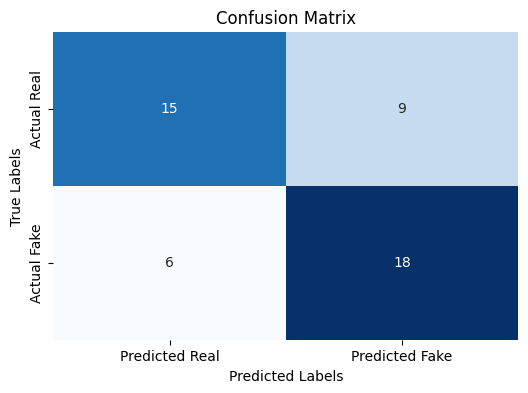

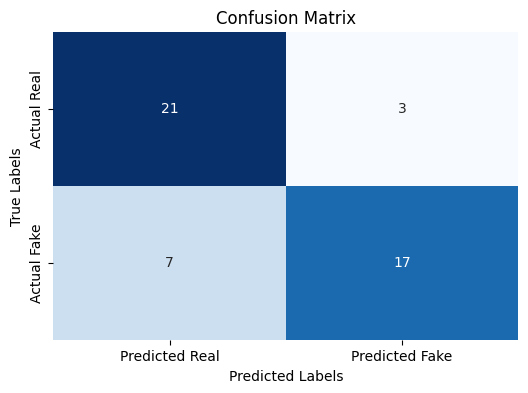

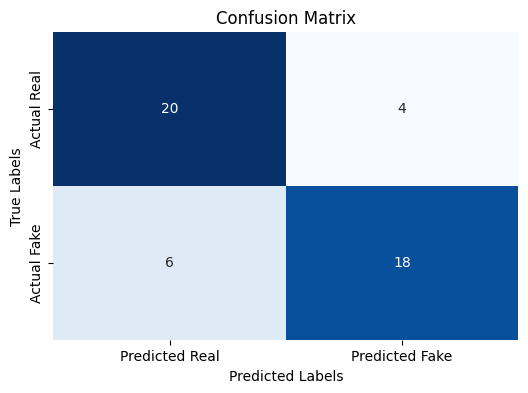

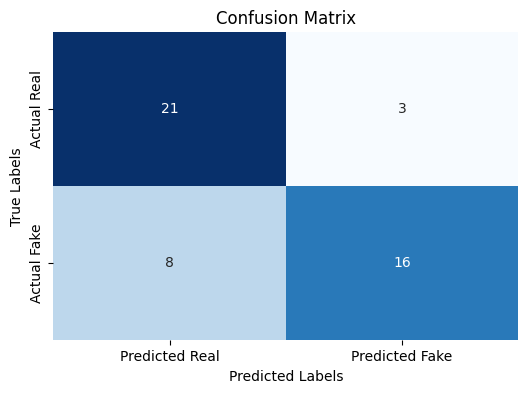

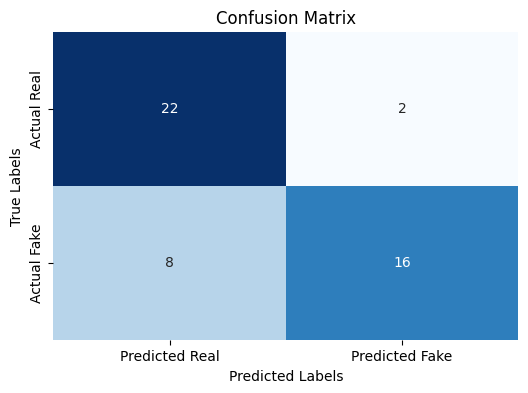


 precision =  81.317 
 
 recall =  70.833 
 
 f1 =  75.346 
 
 accuracy =  76.667 
 
 AUROC =  84.861 
 
 Average Precision =  85.851 



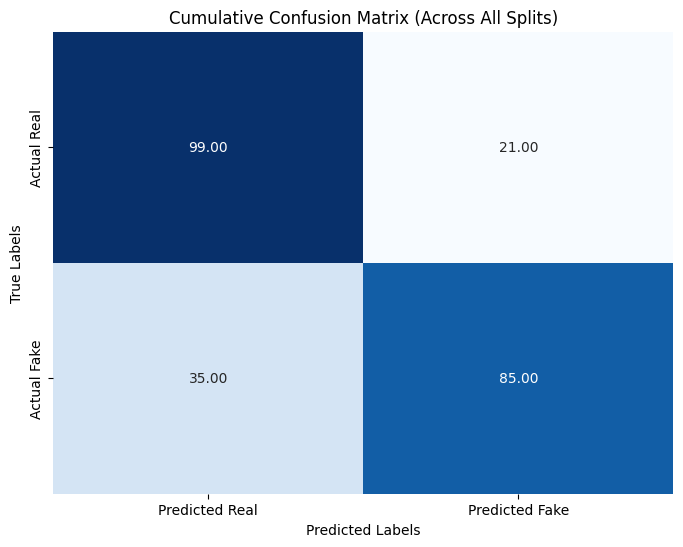

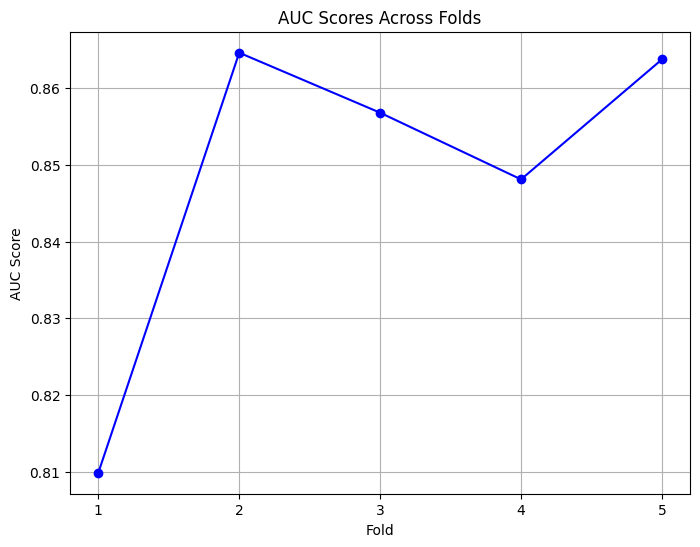

In [ ]:
X = merged_df.drop(columns=['label']).values
y = merged_df["label"].values


# Apply standard scaling to the feature matrix
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


run_classification(X,y)